# Denoising Diffusion Models

Refering to ['Denoising Diffusion Implicit Models' tutorial](https://keras.io/examples/generative/ddim/) created by András Béres available on the Keras website.

In [ ]:
%load_ext autoreload
%autoreload 2
import os


# plt.style.use("seaborn-v0_8-colorblind")

import math

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from keras import ops

from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)
from keras.saving import register_keras_serializable

# Parameters

In [ ]:
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
BATCH_SIZE = 64
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

# Prepare the Dataset

In [ ]:
def preprocess_image(data):
    # center crop image
    height = ops.shape(data["image"])[0]
    width = ops.shape(data["image"])[1]
    crop_size = ops.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0)

def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * BATCH_SIZE)
        .batch(BATCH_SIZE, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.DVFAGD_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.DVFAGD_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.DVFAGD_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


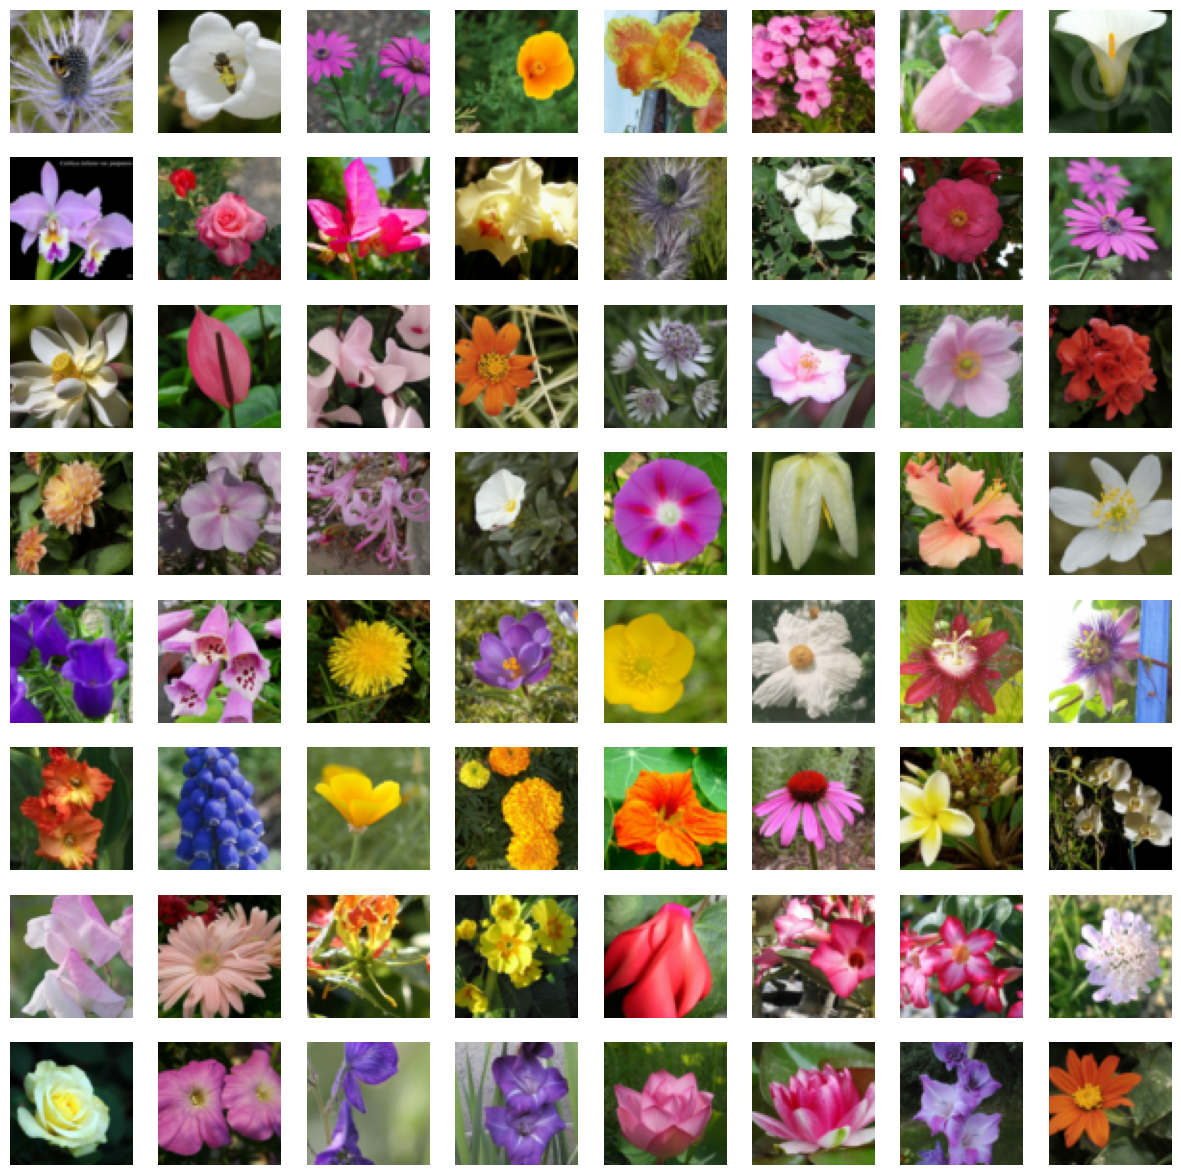

In [ ]:
# show sample batch of train
for images in train_dataset.take(1):
    fig, ax = plt.subplots(nrows=len(images)//8, ncols=8, figsize=(15, 15))
    for i, image in enumerate(images):
        ax[i//8, i%8].axis("off")
        ax[i//8, i%8].imshow(images[i].numpy())
plt.show()

# Denosing Diffusion Model (DDM)

## Diffusion schedules

In [ ]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = tf.math.cumprod(alphas)
    signal_rates = tf.sqrt(alpha_bars)
    noise_rates = tf.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates

In [ ]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi / 2)
    noise_rates = tf.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates

In [ ]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [ ]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(
    diffusion_times
)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(
    diffusion_times
)
(
    offset_cosine_noise_rates,
    offset_cosine_signal_rates,
) = offset_cosine_diffusion_schedule(diffusion_times)

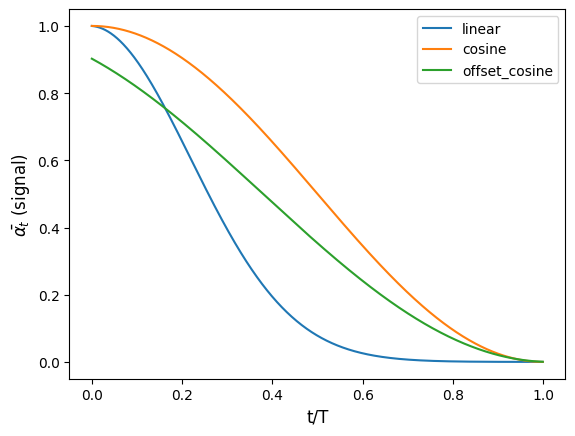

In [ ]:
plt.plot(
    diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

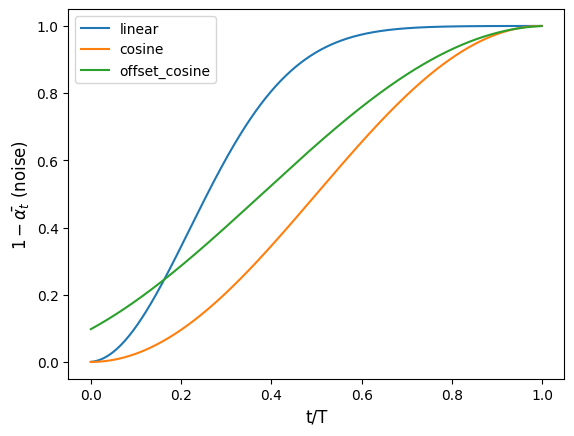

In [ ]:
plt.plot(
    diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_noise_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.show()

## Build the model

In [ ]:
@register_keras_serializable(package="Custom", name="sinusoidal_embedding")
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

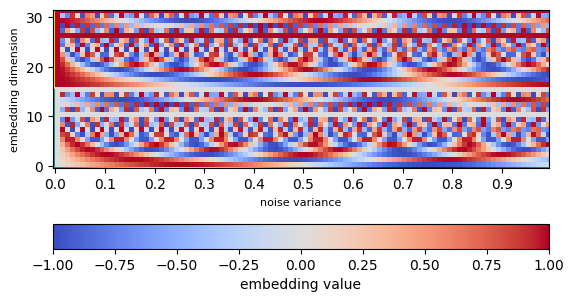

In [ ]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [ ]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [ ]:
# Build the U-Net

noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # input noisy images
x = layers.Conv2D(32, kernel_size=1)(noisy_images) # 64x64x32

noise_variances = layers.Input(shape=(1, 1, 1)) # iput scalar variance
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
) # 64x64x32

x = layers.Concatenate()([x, noise_embedding]) # 64x64x64

skips = [] # keep output from DownBlock to pass to the corresponding UpBlock

x = DownBlock(32, block_depth=2)([x, skips]) # 32x32x32
x = DownBlock(64, block_depth=2)([x, skips]) # 16x16x64
x = DownBlock(96, block_depth=2)([x, skips]) # 8x8x96

x = ResidualBlock(128)(x) # 8x8x128
x = ResidualBlock(128)(x) # 8x8x128

x = UpBlock(96, block_depth=2)([x, skips]) # 16x16x96
x = UpBlock(64, block_depth=2)([x, skips]) # 32x32x64
x = UpBlock(32, block_depth=2)([x, skips]) # 64x64x32

# predict this noise added to the input noisy_images
x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x) # 64x64x3

unet = models.Model([noisy_images, noise_variances], x, name="unet")

unet.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1, 1, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 1, 32)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 64, 64, 32)     │            128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_4           │ (None, 64, 64, 32)     │              0 │ lambda_1[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 64, 64, 64)     │              0 │ conv2d_40[0][0],       │
│ (Concatenate)             │                        │                │ up_sampling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 64, 64, 64)     │            128 │ concatenate_7[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 32)     │         18,464 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 64, 64, 32)     │          2,080 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 64, 64, 32)     │              0 │ conv2d_43[0][0],       │
│                           │                        │                │ conv2d_41[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 64, 64, 32)     │             64 │ add_14[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 64, 64, 32)     │              0 │ conv2d_45[0][0],       │
│                           │                        │                │ add_14[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_3  

 Total params: 1,953,507 (7.45 MB)

 Trainable params: 1,950,627 (7.44 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network) # use this ema for prediction
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True) # mu=0, variance=1
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        # create noisy images by mixing the images with noises
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            # compare the correct noises and the predicted ones for gradient descent
            noise_loss = self.loss(noises, pred_noises)

        # gradient descent
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        # update the weights with the moving average
        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train_dataset) # compute mean and variance of training data

In [ ]:
if LOAD_MODEL:
    ddm.built = True
    ddm.load_weights("./checkpoint/checkpoint.ckpt")

## Train the model

In [ ]:
def display_images(images, ncols=8):
    n_images = len(images)
    nrows = int(np.ceil(n_images / ncols))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 2))
    ax = ax.flatten()  # Flatten in case of a single row to handle indexing properly

    for i in range(ncols * nrows):
        if i < n_images:
            ax[i].imshow(images[i])
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
ddm.compile(
    optimizer=optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.MeanSquaredError(),
)

In [ ]:
# run training and plot generated images periodically
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()

        os.makedirs("./output", exist_ok=True)

        display_images(generated_images)

         # Save generated images
        for i, img in enumerate(generated_images):
            plt.axis('off')
            plt.savefig("./output/generated_img_%03d_%02d.png" % (epoch, i))
            plt.close()


image_generator_callback = ImageGenerator(num_img=8)

ddm.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## Inference

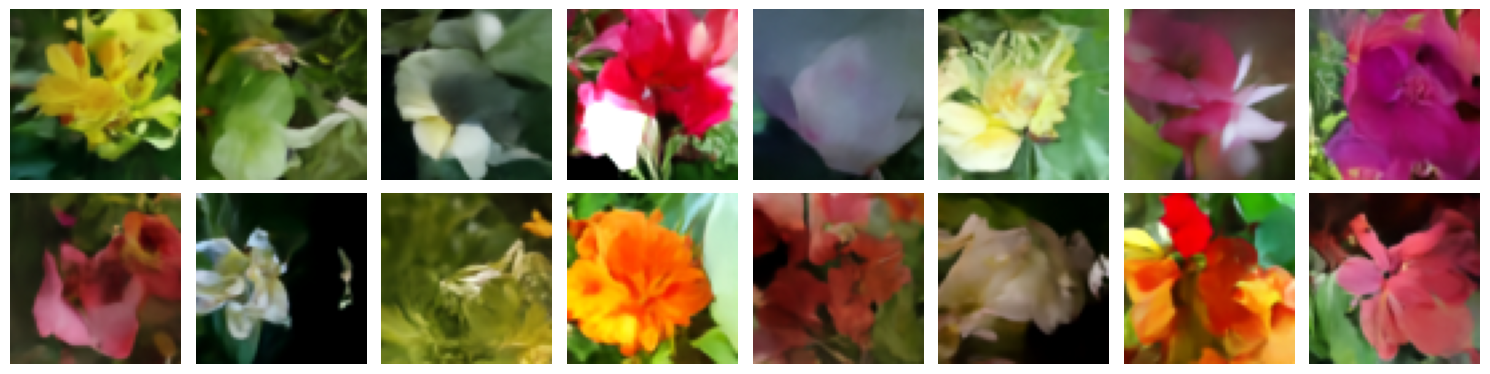

In [ ]:
# Generate some novel images of flowers
generated_images = ddm.generate(num_images=16, diffusion_steps=20).numpy()
display_images(generated_images)

Images generated with 1 diffusion steps


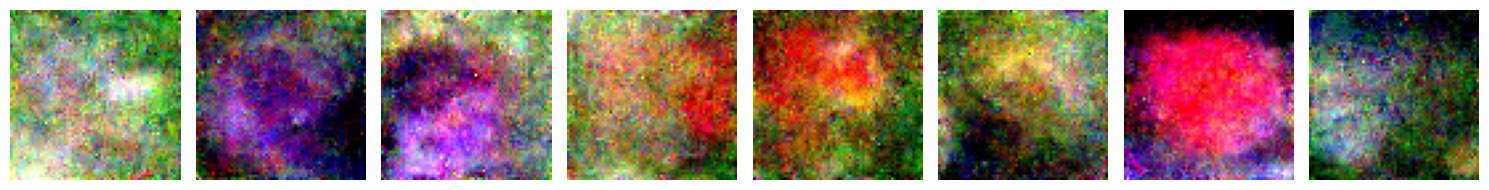

Images generated with 2 diffusion steps


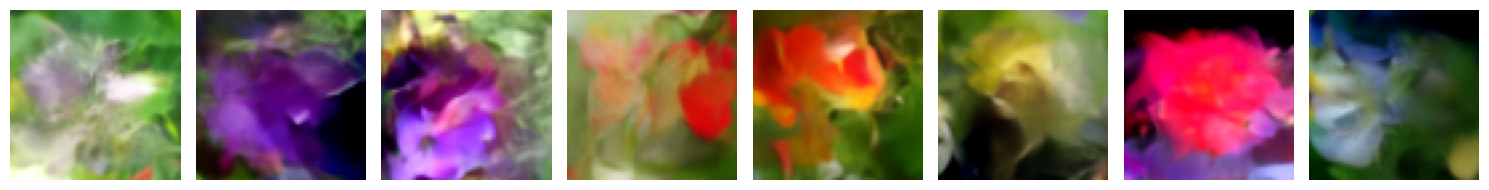

Images generated with 3 diffusion steps


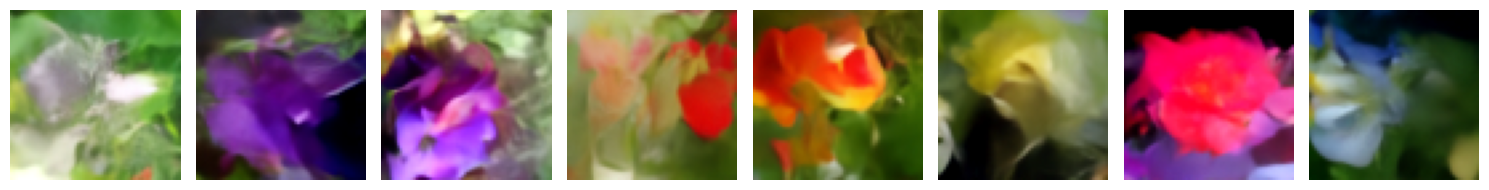

Images generated with 4 diffusion steps


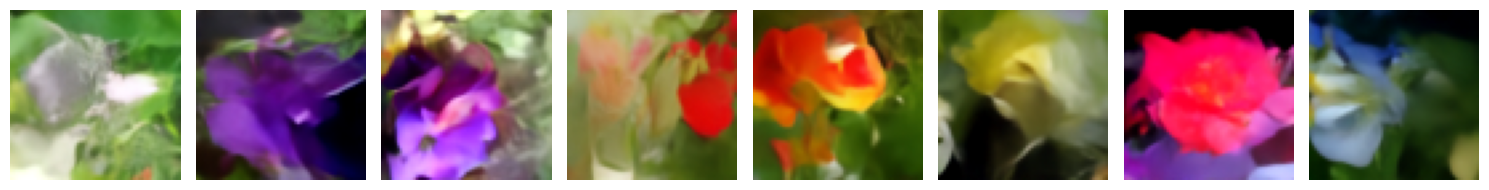

Images generated with 5 diffusion steps


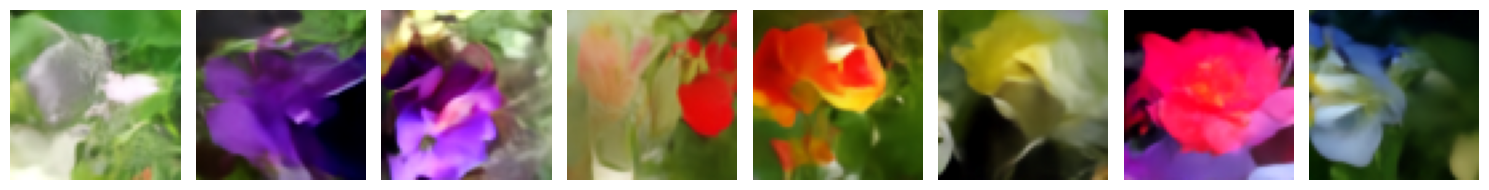

Images generated with 20 diffusion steps


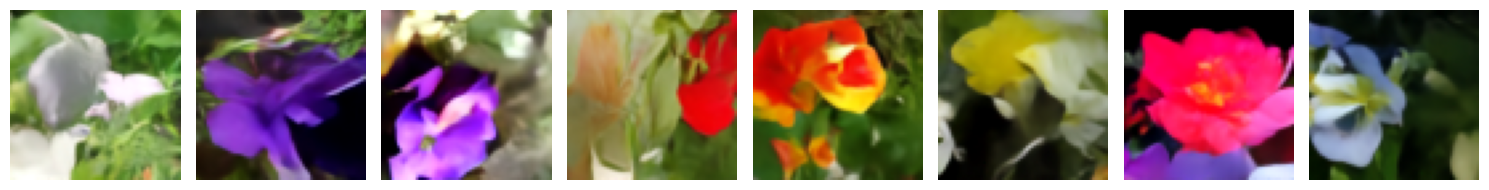

Images generated with 100 diffusion steps


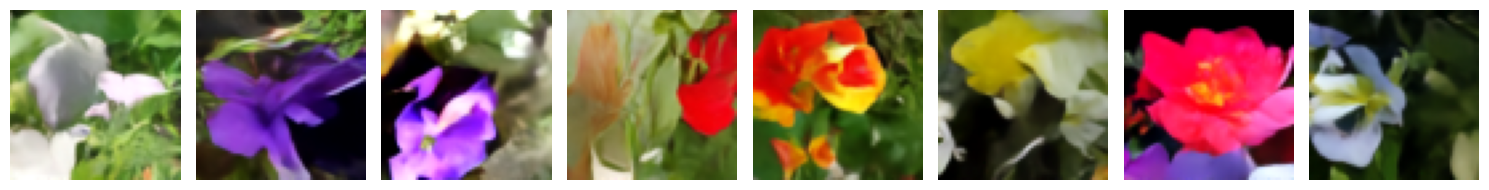

In [ ]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    tf.random.set_seed(42)
    print(f"Images generated with {diffusion_steps} diffusion steps")
    generated_images = ddm.generate(
        num_images=8,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display_images(generated_images)

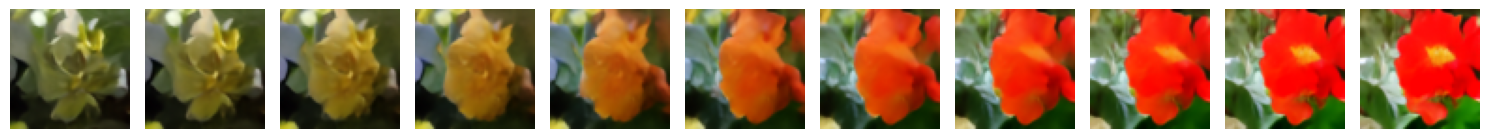

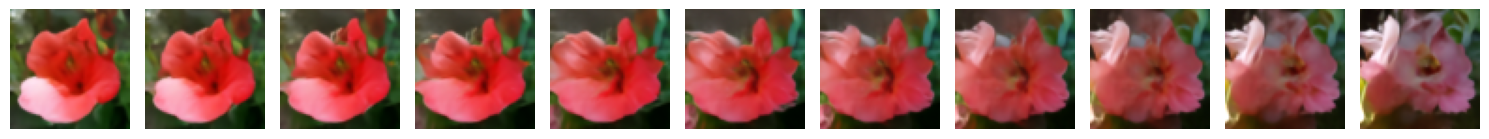

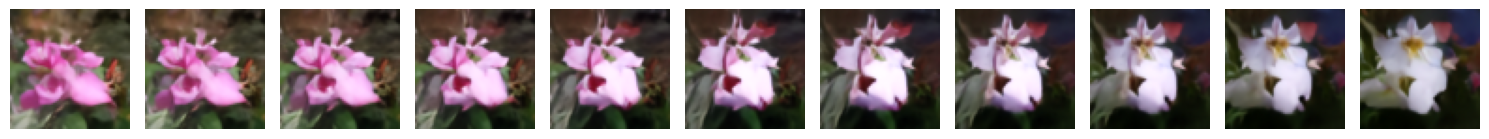

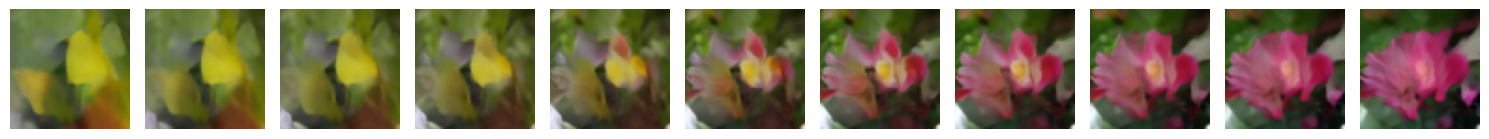

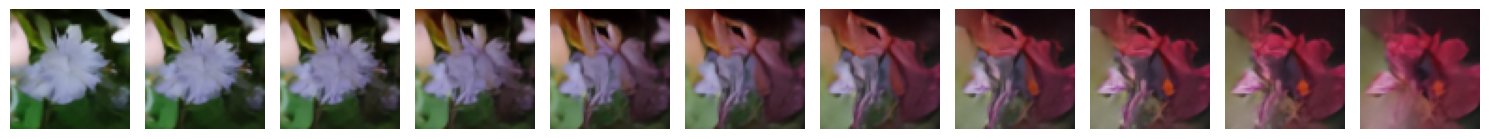

In [ ]:
# Interpolation between two points in the latent space
tf.random.set_seed(100)


def spherical_interpolation(a, b, t):
    # add 2 gausian noises by keeping variance constant
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b


for _ in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    initial_noise = np.array(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    # Convert to tensor
    initial_noise = tf.convert_to_tensor(initial_noise, dtype=tf.float32)

    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    display_images(generated_images, ncols=11)